In [1]:
import tinyarray as ta
import numpy as np
import matplotlib.pyplot as plt
import importlib
import json
import kwant
from dask_quantumtinkerer import Cluster, cluster_options
import adaptive
import pickle
import codes.trijunction as trijunction
import codes.optimization as optimization
import codes.parameters as parameters
from codes.system_functions import diagonalisation, adaptive_two_parameters
from codes.tools import hamiltonian
from codes.utils import eigsh, svd_transformation, dict_update, dep_acc_index, order_wavefunctions

VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1


# Initialize trijunction

In [3]:
from scipy.optimize import minimize, minimize_scalar

In [4]:
with open('/home/tinkerer/trijunction-design/codes/config.json', 'r') as f:
    config = json.load(f)

change_config = [
    {"device": {"thickness": {"dielectric": 1.0}}},
    {"gate": {"channel_width": 13.0, 'angle': np.pi/6, 'gap': 2}},
]

for local_config in change_config:
    config = dict_update(config, local_config)

In [5]:
system = trijunction.Trijunction(config)

In [6]:
system.make_system()

Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix


100%|██████████| 13/13 [00:34<00:00,  2.64s/it]


In [7]:
zero_potential = dict(
    zip(
        ta.array(system.site_coords[:, [0, 1]] - system.offset),
        np.zeros(len(system.site_coords)),
    )
)

depleted_potential = dict(
    zip(
        ta.array(system.site_coords[:, [0, 1]] - system.offset),
        -2*np.ones(len(system.site_coords)),
    )
)

In [8]:
kwant_args = list(system.optimiser_arguments().values())
#kwant_args[-1] = kwant_args[-1][order_wavefunctions(pair)]

In [9]:
params = parameters.junction_parameters()
params.update(potential=zero_potential)

In [10]:
voltages = parameters.pair_voltages(initial=(-1.0e-3, -1.0e-3, -1.0e-3, 2e-3), depleted=-7e-3)

### Topological gap 

In [11]:
params = parameters.junction_parameters()
params.update(potential=depleted_potential)

In [12]:
num_ham = system.trijunction.hamiltonian_submatrix(
            sparse=True, params=system.f_params(**params)
        )

In [13]:
from codes.utils import eigsh
evasl = eigsh(num_ham, 20)

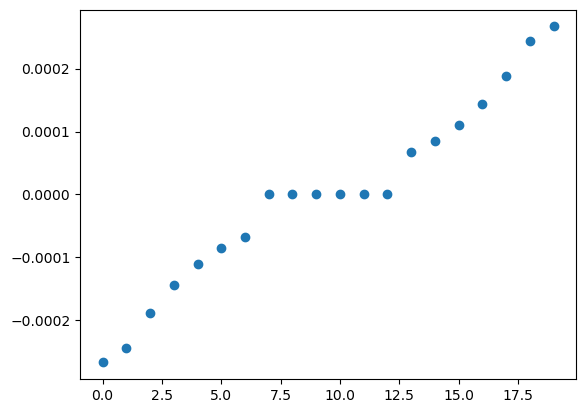

In [14]:
plt.scatter(range(20), evasl)

In [15]:
topo_gap = evasl[14]

In [16]:
topo_gap

8.474218323489755e-05

# Phase space 

## Optimisation routine 

In [23]:
importlib.reload(optimization)

<module 'codes.optimization' from '/home/tinkerer/trijunction-design/analysis/codes/optimization.py'>

In [24]:
%%time
optimal_phases = {}
for pair in pairs:
    params.update(voltages[pair])
    opt_args = tuple([pair, params, kwant_args])

    sol = minimize_scalar(
        optimization.loss,
        args=opt_args, 
        bounds=(0, 2), 
        method="bounded"
    )
    
    optimal_phases[pair] = parameters.phase_pairs(pair, sol.x)

CPU times: user 2min 44s, sys: 33.8 s, total: 3min 17s
Wall time: 3min 16s


In [25]:
optimal_phases

{'right-top': {'phi2': 1.1776207522709696, 'phi1': 0},
 'left-top': {'phi2': 0.8223792424334262, 'phi1': 0},
 'left-right': {'phi1': 1.2619927325804274, 'phi2': 0}}

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/opt/conda/lib/python3.10/ssl.py", line 1342, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLEOFError: EOF occurred in violation of protocol (_ssl.c:997)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/opt/conda/lib/python3.10/site-packages/tornado/iostream.py", line 696, in _handle_events
    self._handle_read()
  File "/opt/conda/lib/python3.10/site-packages/tornado/iostream.py", line 1478, in _handle_read
    self._do_ssl_han

## Uniform grid sampling

In [11]:
options = cluster_options()
options.worker_cores = 2
options.worker_memory = 2
options.extra_path = "/home/jtorresluna/trijunction-design/"

In [20]:
# prepare arguments
phis = np.linspace(0, 2, 50) * np.pi
phases = {}

for pair in pairs:
    phases[pair] = [parameters.phase_pairs(pair, phi) for phi in phis]

In [21]:
# fixed voltage matrices
fixed_linear_matrices = [
    sum(
        [volts[key] * system.linear_terms[key] for key in system.linear_terms.keys()]
    ) for volts in voltages.values()
]

In [16]:
%%time
phase_relations = {}

cluster = Cluster(options)

cluster.scale(50)
client = cluster.get_client()
client.wait_for_workers(1)
print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/192f5580230e4ad0b78966cb00741cde/status
CPU times: user 2 s, sys: 481 ms, total: 2.48 s
Wall time: 2min 31s


In [22]:
scattered_trijunction = client.scatter(system.trijunction, broadcast=True)
scattered_f_params = client.scatter(system.f_params, broadcast=True)
scattered_linear_terms = client.scatter(fixed_linear_matrices, broadcast=True)

In [23]:
%%time
for i, pair in enumerate(pairs):
    futures = client.map(
        diagonalisation,
        phases[pair],
        trijunction=scattered_trijunction,
        f_params=scattered_f_params,
        linear_terms=scattered_linear_terms[i],
        params=params
    )
    phase_relations[pair] = client.gather(futures)

CPU times: user 50.4 s, sys: 8.45 s, total: 58.8 s
Wall time: 4min 39s


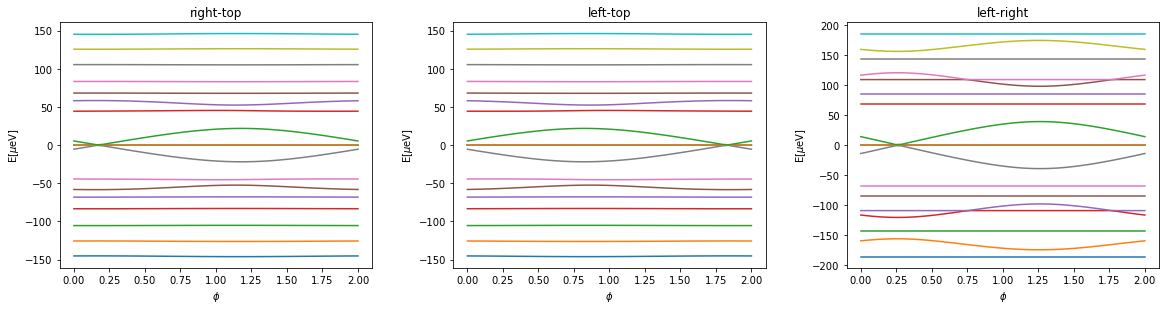

In [24]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))
fig.tight_layout(w_pad=5)

for i, pair in enumerate(pairs):

    phase = 1e6*np.array(phase_relations[pair])

    axes[i].set_title(pair)
    axes[i].set_xlabel(r'$\phi$')
    axes[i].set_ylabel(r'E[$\mu$eV]')

    axes[i].plot(phis/np.pi, phase)
    #opt_phase = list(list(optimal_phases.values())[i].values())[0]
    #axes[i].vlines(opt_phase, ymin=-np.max(phase), ymax=np.max(phase))

In [25]:
optimal_phases = {}
for pair in pairs:
    optimal_phi = phis[np.argmax(np.array(phase_relations[pair]).T[12])]
    optimal_phases[pair] = parameters.phase_pairs(pair, optimal_phi)

In [27]:
optimal_phases

{'right-top': {'phi2': 3.7186198756777142, 'phi1': 0},
 'left-top': {'phi2': 2.5645654315018716, 'phi1': 0},
 'left-right': {'phi1': 3.975076418827901, 'phi2': 0}}

In [12]:
optimal_phases = {'right-top': {'phi2': 3.7186198756777142, 'phi1': 0},
 'left-top': {'phi2': 2.5645654315018716, 'phi1': 0},
 'left-right': {'phi1': 3.975076418827901, 'phi2': 0}}

In [28]:
cluster.close()

# Voltage space exploration

## Optimisation 

In [161]:
dep_index, acc_index = dep_acc_index(
            system.poisson_system,
            system.site_indices,
            system.geometry,
            pair,
        )

In [158]:
ham = hamiltonian(
    kwant_system=system.trijunction,
    linear_terms=system.linear_terms,
    params_fn=system.f_params,
    **params,
)

In [159]:
ham

<115112x115112 sparse matrix of type '<class 'numpy.complex128'>'
	with 1181856 stored elements in Compressed Sparse Row format>

In [163]:
kwant_grid = [site.pos for site in system.trijunction.sites]

In [18]:
# loss to optimize voltages
params.update(optimal_phase)
opt_args = tuple([pair, params, kwant_args])
optimization.loss(x, *opt_args)

3.6413198571384764

In [ ]:
sol1 = minimize(
            optimization.loss,
            x,
            args=opt_args,
            method="trust-constr",
            options={
                "verbose": 2,
                "initial_tr_radius": 1e-3,
                # "gtol": 1e-1,
            },
        )

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   5   |   0   | +3.6413e+00 | 1.00e-03 | 2.41e+03 | 0.00e+00 |
|   2   |  10   |   1   | -2.1138e+00 | 7.00e-03 | 6.44e+03 | 0.00e+00 |
|   3   |  15   |   2   | -5.1649e+00 | 7.00e-03 | 4.05e+01 | 0.00e+00 |
|   4   |  20   |   3   | -5.1652e+00 | 7.00e-03 | 4.03e+01 | 0.00e+00 |
|   5   |  25   |   5   | -5.1652e+00 | 1.61e-03 | 4.03e+01 | 0.00e+00 |
|   6   |  30   |   6   | -5.1652e+00 | 8.07e-04 | 4.03e+01 | 0.00e+00 |
|   7   |  35   |   7   | -5.1652e+00 | 2.99e-04 | 4.03e+01 | 0.00e+00 |
|   8   |  40   |   8   | -5.1889e+00 | 2.09e-03 | 1.59e+02 | 0.00e+00 |
|   9   |  45   |  11   | -5.1889e+00 | 2.53e-04 | 1.59e+02 | 0.00e+00 |
|  10   |  50   |  13   | -5.2199e+00 | 1.77e-03 | 8.09e+02 | 0.00e+00 |
|  11   |  55   |  15   | -5.2199e+00 | 8.87e-04 | 8.09e+02 | 0.00e+00 |
|  12   |  60   |  18   | -5.2199e+00 | 2.96e-04 | 

In [93]:
params.update(parameters.voltage_dict(sol1.x))
opt_args = tuple([pair, params, kwant_args])

In [59]:
optimiser_args = system.optimiser_arguments()

numerical_hamiltonian = hamiltonian(system.trijunction, 
                                    optimiser_args['linear_terms'], 
                                    optimiser_args['kwant_params_fn'], 
                                    **params)

In [61]:
energies, wave_functions = eigsh(
                numerical_hamiltonian.tocsc(),
                6,
                sigma=0,
                return_eigenvectors=True,
)

In [75]:
transformed_hamiltonian = svd_transformation(
    energies, wave_functions, reference_wave_functions
)

desired = np.abs(transformed_hamiltonian[0, 1])
undesired = np.linalg.norm(transformed_hamiltonian[2:])

In [77]:
desired

2.430561344761288e-05

## Adaptive exploration 

In [17]:
plunger_min = -7e-3
plunger_max = 7e-3

bounds = [
    (plunger_min, plunger_max),
    (plunger_min, plunger_max),
]

In [14]:
cluster = await Cluster(options, asynchronous=True)

await cluster.scale(50)
client = await cluster.get_client()
await client.wait_for_workers(1)
print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/9610911007bf4efaba20bdd876445802/status


### Single calculation 

In [51]:
pair = 'right-top'

In [52]:
voltages = parameters.pair_voltages(initial=(-1.0e-3, -1.0e-3, -1.0e-3, -7e-3), depleted=-7e-3)

In [53]:
params = parameters.junction_parameters()
params.update(potential=zero_potential)
params.update(optimal_phases[pair])
base_ham = system.trijunction.hamiltonian_submatrix(sparse=True, params=system.f_params(**params))

In [54]:
scattered_base_ham = await client.scatter(base_ham, broadcast=True)
scattered_linear_matrices = await client.scatter(system.linear_terms, broadcast=True)

In [55]:
async def f_async(xy):
    future = client.submit(
        adaptive_two_parameters,
        xy,
        trijunction=scattered_base_ham,
        linear_terms=scattered_linear_matrices,
        keys=('right', 'top'),
        params=voltages[pair]
    )

    return await future

In [56]:
learner = adaptive.Learner2D(f_async, bounds=bounds)

In [57]:
runner = adaptive.AsyncRunner(
    learner,
    goal=lambda l: l.loss() < 0.001,
    ntasks=100
)

### Sampling of three-dimensional voltage space for each pair

In [80]:
plunger_min = -7e-3
plunger_max = 7e-3

bounds = [
    (plunger_min, plunger_max),
    (plunger_min, plunger_max),
]

In [81]:
options = cluster_options()
options.worker_cores = 1
options.worker_memory = 4
options.extra_path = "/home/jtorresluna/trijunction-design/"

In [ ]:
cluster = await Cluster(options, asynchronous=True)

await cluster.scale(100)
client = await cluster.get_client()
await client.wait_for_workers(1)
print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/abeab1f04b1446e7acc6942f6aaf272b/status


In [84]:
# cuts along accumulation voltage
accumulation_voltages = np.arange(5, 10) * 1e-3

# initial parameters
params = parameters.junction_parameters()
params.update(potential=zero_potential)
voltages = parameters.pair_voltages(initial=(-1.0e-3, -1.0e-3, -1.0e-3, -7e-3), depleted=-7e-3)

# distribute voltage matrices
scattered_linear_matrices = await client.scatter(system.linear_terms, broadcast=True)

In [ ]:
pair_couplings = {}

for pair in pairs:
    accum_couplings = {}
    
    params.update(optimal_phases[pair])
    
    base_ham = system.trijunction.hamiltonian_submatrix(
        sparse=True, params=system.f_params(**params)
    )
    scattered_base_ham = await client.scatter(base_ham, broadcast=True)
    
    for voltage in accumulation_voltages:
        
        voltages[pair]['global_accumul'] = voltage
        
        async def f_async(xy):
            future = client.submit(
                adaptive_two_parameters,
                xy,
                trijunction=scattered_base_ham,
                linear_terms=scattered_linear_matrices,
                keys=pair.split('-'),
                params=voltages[pair]
            )

            return await future
        
        learner = adaptive.Learner2D(f_async, bounds=bounds)
        runner = adaptive.AsyncRunner(
                        learner,
                        goal=lambda l: l.loss() < 0.01,
                        ntasks=100
                    )
        
        await runner.task
        _, _, z = learner.interpolated_on_grid()
        
        with open(f'../data/{pair}_{voltage}.pickle', 'wb') as handle:
            pickle.dump(z, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        accum_couplings[voltage] = z
    
    with open(f'../data/{pair}.pickle', 'wb') as handle:
        pickle.dump(accum_couplings, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    pair_couplings[pair] = accum_couplings

#### Results 

In [38]:
# compute maxima of all dictionaries
mmax = 0

for pair in pairs:

    with open(f'../data/{pair}.pickle', 'rb') as handle:
        data = pickle.load(handle)

    for el in data.values():
        if np.max(el) > mmax:
            mmax = np.max(el)

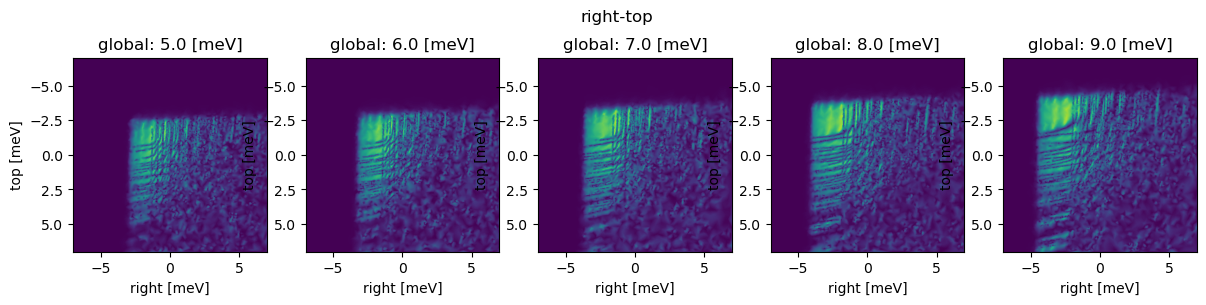

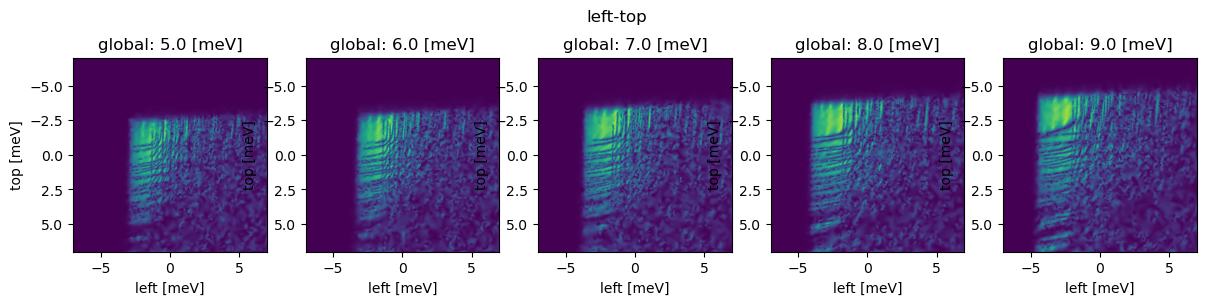

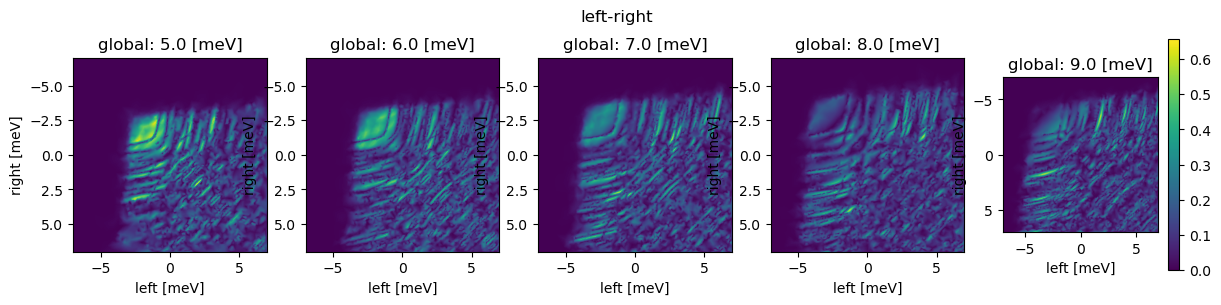

In [37]:
for pair in pairs:
    gates = pair.split('-')
    with open(f'../data/{pair}.pickle', 'rb') as handle:
        data = pickle.load(handle)
    fig, ax = plt.subplots(ncols=len(data), figsize=(14.5, 3))
    fig.suptitle(pair)
    for i, (key, val) in enumerate(data.items()):
        plot = ax[i].imshow(val/topo_gap, extent=(-7, 7, 7, -7), vmin=0, vmax=mmax/topo_gap)
        ax[i].set_title(f'global: {np.round(key*1e3, 1)} [meV]')
        ax[i].set_xlabel(f'{gates[0]} [meV]')
        ax[i].set_ylabel(f'{gates[1]} [meV]')
plt.colorbar(plot)